<a href="https://colab.research.google.com/github/BaoNguyen151654/How-Soccer-Teams-Come-Back-from-Behind-in-Away-Matches-Evidence-from-the-English-Premier-League/blob/main/ComebackAnalytics_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpyro[jax]

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from scipy.stats import beta
import pymc as pm
import arviz as az
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [3]:
df_12 = pd.read_csv('season-1112.csv')
df_13 = pd.read_csv('season-1213.csv')
df_14 = pd.read_csv('season-1314.csv')
df_15 = pd.read_csv('season-1415.csv')
df_16 = pd.read_csv('season-1516.csv')
df_17 = pd.read_csv('season-1617.csv')
df_18 = pd.read_csv('season-1718.csv')
df_19 = pd.read_csv('season-1819.csv')
df_20 = pd.read_csv('season-1920.csv')
df_21 = pd.read_csv('season-2021.csv')
df_22 = pd.read_csv('season-2122.csv')
df_23 = pd.read_csv('season-2223.csv')
df_24 = pd.read_csv('season-2324.csv')
df_25 = pd.read_csv('season-2425.csv')

In [4]:
df = pd.concat([df_12,df_13,df_14,df_15,df_16,df_17,df_18,df_19,df_20,df_21,df_22,df_23,df_24,df_25],axis=0, ignore_index=True)
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,13/08/11,Blackburn,Wolves,1,2,A,1,1,D,K Friend,...,8,4,14,10,12,6,4,2,0,0
1,13/08/11,Fulham,Aston Villa,0,0,D,0,0,D,L Mason,...,9,1,10,18,2,3,2,4,0,0
2,13/08/11,Liverpool,Sunderland,1,1,D,1,0,H,P Dowd,...,4,6,17,12,6,3,4,4,0,0
3,13/08/11,Newcastle,Arsenal,0,0,D,0,0,D,P Walton,...,1,4,9,11,2,5,3,5,0,1
4,13/08/11,QPR,Bolton,0,4,A,0,1,A,M Atkinson,...,7,7,9,16,3,2,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,25/05/25,Newcastle,Everton,0,1,A,0,0,D,T Harrington,...,6,6,12,9,12,3,1,4,0,0
5316,25/05/25,Nott'm Forest,Chelsea,0,1,A,0,0,D,A Taylor,...,2,2,10,11,7,4,2,2,0,0
5317,25/05/25,Southampton,Arsenal,1,2,A,0,1,A,D Bond,...,2,8,7,8,5,8,0,0,0,0
5318,25/05/25,Tottenham,Brighton,1,4,A,1,0,H,R Jones,...,2,8,13,8,2,11,3,1,0,0


In [5]:
df['away_comeback'] = ((df['FTR'] == 'A') & (df['HTR'] == 'H')).astype(int)
df['home_lead_1'] = (df['HTHG'] - df['HTAG']).clip(lower=0)
comeback_matches = df[df['away_comeback'] == 1]
comeback_matches

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HF,AF,HC,AC,HY,AY,HR,AR,away_comeback,home_lead_1
89,29/10/11,Chelsea,Arsenal,3,5,A,2,1,H,A Marriner,...,7,18,3,2,2,3,0,0,1,1
154,17/12/11,Wolves,Stoke,1,2,A,1,0,H,A Taylor,...,8,11,7,5,2,4,0,0,1,1
217,21/01/12,Wolves,Aston Villa,2,3,A,2,1,H,M Oliver,...,11,8,12,3,1,0,1,0,1,1
233,04/02/12,QPR,Wolves,1,2,A,1,0,H,M Clattenburg,...,7,14,7,3,0,3,1,0,1,1
246,11/02/12,Swansea,Norwich,2,3,A,1,0,H,M Atkinson,...,6,12,6,8,0,2,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265,20/04/25,Fulham,Chelsea,1,2,A,1,0,H,A Taylor,...,13,9,6,4,1,3,0,0,1,1
5275,26/04/25,Southampton,Fulham,1,2,A,1,0,H,T Harrington,...,10,12,0,13,1,1,0,0,1,1
5284,03/05/25,Arsenal,Bournemouth,1,2,A,1,0,H,J Gillett,...,7,16,2,3,0,2,0,0,1,1
5304,18/05/25,Brentford,Fulham,2,3,A,2,1,H,J Gillett,...,12,8,5,3,4,4,0,0,1,1


In [6]:
drop = ['FTHG', 'FTAG', 'Referee', 'HS', 'AS','FTR','HTR','HTHG','HTAG']
df1 = df.drop(drop, axis=1)
df1 = df1[df1['home_lead_1'] > 0]
df1

,Date,HomeTeam,AwayTeam,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,away_comeback,home_lead_1
2,13/08/11,Liverpool,Sunderland,4,6,17,12,6,3,4,4,0,0,0,1
10,20/08/11,Aston Villa,Blackburn,6,6,9,13,5,4,3,0,0,0,0,2
16,21/08/11,Norwich,Stoke,7,5,13,12,3,6,0,2,1,0,0,1
17,21/08/11,Wolves,Fulham,7,4,7,10,7,8,2,2,0,0,0,2
21,27/08/11,Chelsea,Norwich,8,6,17,14,8,6,2,2,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5304,18/05/25,Brentford,Fulham,6,7,12,8,5,3,4,4,0,0,1,1
5305,18/05/25,Leicester,Ipswich,3,2,15,12,2,2,1,0,0,0,0,1
5308,20/05/25,Crystal Palace,Wolves,10,3,14,8,0,10,1,2,0,0,0,1
5309,20/05/25,Man City,Bournemouth,5,2,7,13,3,1,1,3,1,1,0,2


In [7]:
model = smf.logit(
    'away_comeback ~ AST+HF+HST+AF+HC+AC+HY+AY+HR+AR+home_lead_1',
    data=df1
).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.180821
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          away_comeback   No. Observations:                 1825
Model:                          Logit   Df Residuals:                     1813
Method:                           MLE   Df Model:                           11
Date:                Mon, 16 Feb 2026   Pseudo R-squ.:                  0.2060
Time:                        20:49:55   Log-Likelihood:                -330.00
converged:                       True   LL-Null:                       -415.59
Covariance Type:            nonrobust   LLR p-value:                 6.728e-31
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.5861      0.809     -0.725      0.469      -2.171       0.999
AST             0.2990    

In [8]:
df1['away_comeback'].value_counts()

,count
away_comeback,
0,1715
1,110


In [9]:
X_cols = ['AST','HF','HST','AF','HC','AC','HY','AY','HR','AR','home_lead_1']
X = df1[X_cols]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

       Variable        VIF
0         const  45.019332
1           AST   1.176121
2            HF   1.193377
3           HST   1.328959
4            AF   1.231856
5            HC   1.250440
6            AC   1.282166
7            HY   1.264185
8            AY   1.235652
9            HR   1.029591
10           AR   1.024371
11  home_lead_1   1.091098


In [10]:
dw = durbin_watson(model.resid_dev)
print(dw)

1.9263494659755964


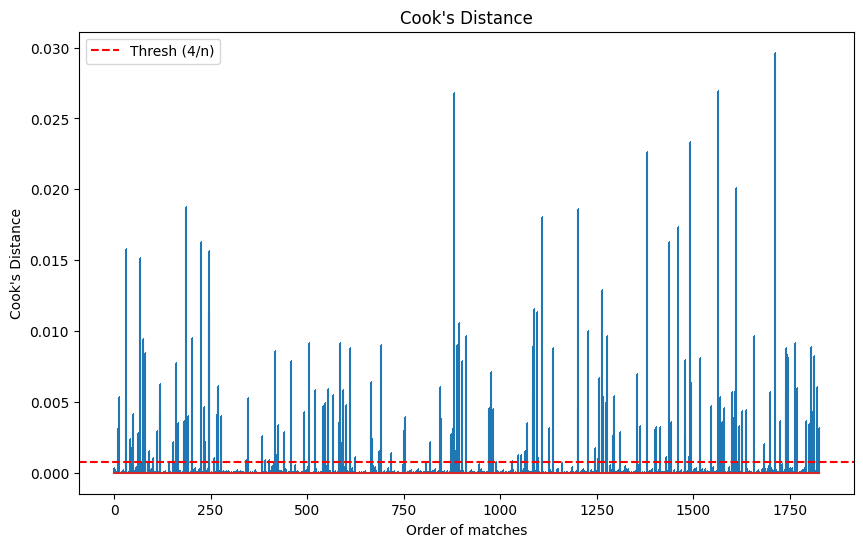

In [11]:
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title("Cook's Distance")
plt.xlabel('Order of matches')
plt.ylabel("Cook's Distance")

threshold = 4 / len(df)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Thresh (4/n)')
plt.legend()
plt.show()

In [12]:
influential_idx = np.where(cooks_d > threshold)[0]

print("Total points that are out of threshold:", len(influential_idx))
print("Index of points:", influential_idx)

Total points that are out of threshold: 158
Index of points: [  11   12   30   31   42   45   50   62   67   74   79   87   90  102
  112  119  120  152  157  161  165  180  181  186  192  202  224  234
  235  245  247  258  267  269  277  343  347  383  390  401  414  418
  422  425  439  459  493  504  521  542  543  545  554  555  568  583
  585  591  593  601  611  625  666  669  686  691  718  751  753  817
  845  847  872  878  881  882  887  894  900  912  970  976  982 1030
 1047 1053 1064 1068 1085 1086 1088 1095 1098 1109 1126 1136 1200 1202
 1227 1244 1254 1255 1263 1265 1275 1277 1291 1295 1310 1353 1363 1380
 1401 1402 1413 1429 1437 1442 1460 1477 1479 1488 1491 1494 1516 1546
 1564 1569 1570 1575 1578 1599 1604 1608 1611 1613 1617 1626 1627 1635
 1658 1684 1698 1711 1723 1739 1740 1742 1745 1763 1767 1792 1800 1805
 1807 1813 1820 1824]


In [13]:
influential_idx = influential_idx.tolist()

In [14]:
df_influential = df1.iloc[influential_idx]
df_influential['away_comeback'].value_counts()

,count
away_comeback,
1,110
0,48


In [15]:
for col in ['AST','HST','HF','AF','HC','AC']:
    df1[col] = df1[col] + 0.001
cont_vars = ['AST','HST','HF','AF','HC','AC']

for v in cont_vars:
    df1[f'{v}_log'] = df1[v] * np.log(df1[v])

In [16]:
formula = """
away_comeback ~
AST + AST_log +
HST + HST_log +
HF + HF_log +
AF + AF_log +
HC + HC_log +
AC + AC_log +
HY + AY + HR + AR + home_lead_1
"""
df1['AwayTeam_id'] = pd.factorize(df1['AwayTeam'])[0]
df1['HomeTeam_id'] = pd.factorize(df1['HomeTeam'])[0]

bt_model = smf.logit(formula, data=df1).fit(
    cov_type='cluster',
    cov_kwds={'groups': df1[['AwayTeam_id', 'HomeTeam_id']]}
)

Optimization terminated successfully.
         Current function value: 0.174117
         Iterations 9


In [17]:
print(bt_model.summary())

                           Logit Regression Results                           
Dep. Variable:          away_comeback   No. Observations:                 1825
Model:                          Logit   Df Residuals:                     1807
Method:                           MLE   Df Model:                           17
Date:                Mon, 16 Feb 2026   Pseudo R-squ.:                  0.2354
Time:                        20:49:55   Log-Likelihood:                -317.76
converged:                       True   LL-Null:                       -415.59
Covariance Type:              cluster   LLR p-value:                 2.137e-32
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.2759      2.714     -1.944      0.052     -10.595       0.043
AST             1.9412      0.552      3.514      0.000       0.859       3.024
AST_log        -0.5942      0.203     -2.929    

In [18]:
df1['AST'] = df1['AST'] + 0.001
df1[f'log_{'AST'}'] = np.log(df1['AST'])

In [19]:
formula = """
away_comeback ~ log_AST + HST + HF + AF + AC + HC + HY + AY + HR + AR + home_lead_1
"""
model_log = smf.logit(formula, data=df1).fit(
    cov_type='cluster',
    cov_kwds={'groups': df1[['AwayTeam_id', 'HomeTeam_id']]}
)
print(model_log.summary())

Optimization terminated successfully.
         Current function value: 0.176137
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:          away_comeback   No. Observations:                 1825
Model:                          Logit   Df Residuals:                     1813
Method:                           MLE   Df Model:                           11
Date:                Mon, 16 Feb 2026   Pseudo R-squ.:                  0.2265
Time:                        20:49:55   Log-Likelihood:                -321.45
converged:                       True   LL-Null:                       -415.59
Covariance Type:              cluster   LLR p-value:                 1.995e-34
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.5964      0.773     -2.065      0.039      -3.111      -0.082
log_AST         1.7001    

In [20]:
marginal_effects = model_log.get_margeff()
print(marginal_effects.summary())

        Logit Marginal Effects       
Dep. Variable:          away_comeback
Method:                          dydx
At:                           overall
                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
log_AST         0.0826      0.013      6.238      0.000       0.057       0.109
HST            -0.0117      0.002     -5.370      0.000      -0.016      -0.007
HF             -0.0011      0.001     -1.115      0.265      -0.003       0.001
AF             -0.0025      0.001     -1.678      0.093      -0.005       0.000
AC             -0.0015      0.002     -0.973      0.331      -0.004       0.002
HC              0.0009      0.002      0.392      0.695      -0.004       0.005
HY              0.0039      0.005      0.867      0.386      -0.005       0.013
AY              0.0086      0.005      1.571      0.116      -0.002       0.019
HR              0.0540      0.014      3.767    

In [21]:
summary_df = pd.DataFrame({
    'coef': model_log.params,
    'std_err': model_log.bse,
    'z': model_log.tvalues,
    'p_value': model_log.pvalues,
    'conf_lower': model_log.conf_int()[0],
    'conf_upper': model_log.conf_int()[1]
})

sig_df = summary_df[summary_df['p_value'] < 0.05]

In [22]:
sig_df

,coef,std_err,z,p_value,conf_lower,conf_upper
Intercept,-1.596387,0.772906,-2.065435,3.888184e-02,-3.111255,-0.081519
log_AST,1.700053,0.213141,7.976187,1.509230e-15,1.282304,2.117801
HST,-0.240928,0.039905,-6.037602,1.564209e-09,-0.319140,-0.162717
HR,1.111615,0.304733,3.647834,2.644602e-04,0.514350,1.708881
home_lead_1,-1.630798,0.539601,-3.022227,2.509223e-03,-2.688398,-0.573199


In [23]:
df2 = df1.copy()

scaler = StandardScaler()

# Home Attack
home_z = scaler.fit_transform(df2[['HST','HC']])
df2['home_attack'] = home_z[:,0] + home_z[:,1]

# Away Attack
away_z = scaler.fit_transform(df2[['AST','AC']])
df2['away_attack'] = away_z[:,0] + away_z[:,1]

# Home Aggressive
home_z = scaler.fit_transform(df2[['HF','HY','HR']])
df2['home_aggressive'] = home_z[:,0] + home_z[:,1] + home_z[:,2]

# Away Aggressive
away_z = scaler.fit_transform(df2[['AF','AY','AR']])
df2['away_aggressive'] = away_z[:,0] + away_z[:,1] + away_z[:,2]

In [24]:
df2

,Date,HomeTeam,AwayTeam,HST,AST,HF,AF,HC,AC,HY,...,AF_log,HC_log,AC_log,AwayTeam_id,HomeTeam_id,log_AST,home_attack,away_attack,home_aggressive,away_aggressive
2,13/08/11,Liverpool,Sunderland,4.001,6.002,17.001,12.001,6.001,3.001,4,...,29.822365,10.753349,3.297936,0,0,1.792093,-0.642462,0.333733,3.755705,1.776983
10,20/08/11,Aston Villa,Blackburn,6.001,6.002,9.001,13.001,5.001,4.001,3,...,33.347907,8.049799,5.547564,1,1,1.792093,-0.326222,0.687912,0.619850,-1.084561
16,21/08/11,Norwich,Stoke,7.001,5.002,13.001,12.001,3.001,6.001,0,...,29.822365,3.297936,10.753349,2,2,1.609838,-0.681786,0.969486,3.923619,0.206111
17,21/08/11,Wolves,Fulham,7.001,4.002,7.001,10.001,7.001,8.001,2,...,23.029154,13.624317,16.638612,3,3,1.386794,0.688037,1.251059,-0.774423,-0.354290
21,27/08/11,Chelsea,Norwich,8.001,6.002,17.001,14.001,8.001,6.001,2,...,36.950442,16.638612,10.753349,4,4,1.792093,1.359841,1.396272,2.128213,4.281983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5304,18/05/25,Brentford,Fulham,6.001,7.002,12.001,8.001,5.001,3.001,4,...,16.638612,8.049799,3.297936,3,35,1.946196,-0.326222,0.760519,2.304387,0.656182
5305,18/05/25,Leicester,Ipswich,3.001,2.002,15.001,12.001,2.001,2.001,1,...,29.822365,1.387988,1.387988,38,26,0.694147,-2.341633,-1.727592,0.733941,-1.364761
5308,20/05/25,Crystal Palace,Wolves,10.001,3.002,14.001,8.001,0.001,10.001,1,...,16.638612,-0.006908,23.029154,15,24,1.099279,-0.721110,1.532632,0.443677,-0.914690
5309,20/05/25,Man City,Bournemouth,5.001,2.002,7.001,13.001,3.001,1.001,1,...,33.347907,3.297936,0.001000,28,9,0.694147,-1.340482,-2.081772,2.995783,4.787219


In [25]:
X = df2[['home_attack','away_attack','home_aggressive','away_aggressive']]

In [26]:
wcss_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)

    wcss = kmeans.inertia_  # WCSS được lưu trong thuộc tính inertia_
    wcss_scores.append(wcss)

    print(f"k = {k}")
    print(f"   WCSS = {wcss:.4f}")
    print("-" * 40)

k = 2
   WCSS = 18378.4343
----------------------------------------
k = 3
   WCSS = 15160.1891
----------------------------------------
k = 4
   WCSS = 12856.3165
----------------------------------------
k = 5
   WCSS = 11626.8993
----------------------------------------
k = 6
   WCSS = 10723.2479
----------------------------------------
k = 7
   WCSS = 9896.7031
----------------------------------------
k = 8
   WCSS = 9309.4237
----------------------------------------
k = 9
   WCSS = 8877.8393
----------------------------------------
k = 10
   WCSS = 8489.8701
----------------------------------------


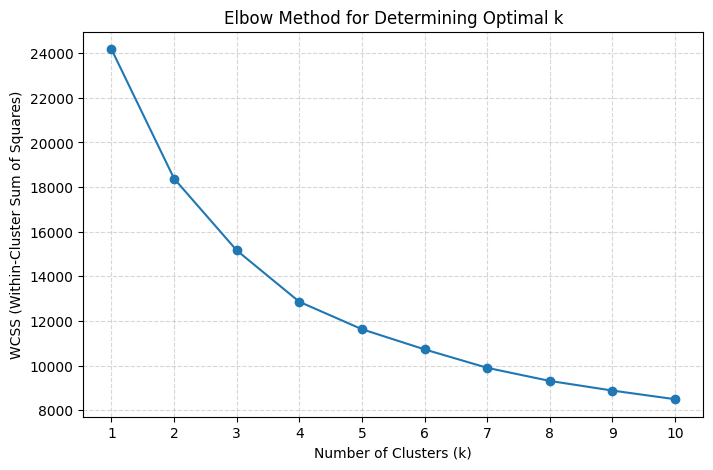

In [27]:
wcss_scores = []

k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss_scores.append(kmeans.inertia_)

# Vẽ biểu đồ WCSS
plt.figure(figsize=(8,5))
plt.plot(k_range, wcss_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Determining Optimal k")
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [28]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
df2['cluster'] = kmeans.labels_

In [29]:
cluster_means = df2.groupby('cluster')[['home_attack','away_attack','home_aggressive','away_aggressive']].mean()
print(cluster_means)

         home_attack  away_attack  home_aggressive  away_aggressive
cluster                                                            
0          -0.001495    -0.365027        -0.134240         2.406733
1           0.600539    -0.505926        -1.146878        -1.187936
2          -0.993918     1.187660         2.029258        -0.332970


In [39]:
cluster_summary = df2.groupby('cluster').agg(
    n_samples=('cluster','count'),
    home_attack_mean=('home_attack','mean'),
    away_attack_mean=('away_attack','mean'),
    home_aggressive_mean=('home_aggressive','mean'),
    away_aggressive_mean=('away_aggressive','mean'),
    home_lead_1_mean=('home_lead_1','mean'),
    away_comeback_count=('away_comeback','sum')
).reset_index()

total_matches = len(df2)
cluster_summary['away_comeback_rate'] = cluster_summary['away_comeback_count'] / total_matches * 100

cluster_summary = cluster_summary.drop(columns=['away_comeback_count'])

In [40]:
cluster_summary

,cluster,n_samples,home_attack_mean,away_attack_mean,home_aggressive_mean,away_aggressive_mean,home_lead_1_mean,away_comeback_rate
0,0,483,-0.001495,-0.365027,-0.134240,2.406733,1.412008,1.095890
1,1,837,0.600539,-0.505926,-1.146878,-1.187936,1.499403,1.424658
2,2,505,-0.993918,1.187660,2.029258,-0.332970,1.267327,3.506849


In [32]:
cluster_counts = (
    df2[df2['away_comeback'] == 1]
    .groupby(['AwayTeam','cluster'])
    .size()
    .reset_index(name='count')
)

away_cluster_mode = (
    cluster_counts
    .sort_values(['AwayTeam','count'], ascending=[True, False])
    .drop_duplicates('AwayTeam')
    [['AwayTeam','cluster']]
)

comeback_total = (
    df2[df2['away_comeback'] == 1]
    .groupby('AwayTeam')
    .size()
    .reset_index(name='total_comebacks')
)

all_teams = df2[['AwayTeam']].drop_duplicates()

away_cluster_full = (
    all_teams
    .merge(away_cluster_mode, on='AwayTeam', how='left')
    .merge(comeback_total, on='AwayTeam', how='left')
)

away_cluster_full['cluster'] = away_cluster_full['cluster'].fillna(0).astype(int)
away_cluster_full['total_comebacks'] = away_cluster_full['total_comebacks'].fillna(0).astype(int)

print(away_cluster_full)

            AwayTeam  cluster  total_comebacks
0         Sunderland        2                1
1          Blackburn        0                0
2              Stoke        0                1
3             Fulham        2                5
4            Norwich        1                1
5             Bolton        0                0
6                QPR        0                0
7            Arsenal        0                3
8            Swansea        2                2
9        Aston Villa        2                2
10             Wigan        0                0
11         Liverpool        1                9
12         Newcastle        0                6
13         West Brom        0                2
14           Chelsea        2               12
15            Wolves        2                9
16           Everton        2                3
17         Tottenham        2                7
18        Man United        2                9
19       Southampton        0                1
20          W

In [33]:
teams_with_cluster = (
    away_cluster_full
    [away_cluster_full['total_comebacks'] != 0]
    .sort_values('total_comebacks', ascending=False)
)

print(teams_with_cluster)

            AwayTeam  cluster  total_comebacks
14           Chelsea        2               12
11         Liverpool        1                9
15            Wolves        2                9
18        Man United        2                9
17         Tottenham        2                7
21          Man City        2                6
20          West Ham        2                6
12         Newcastle        0                6
25    Crystal Palace        2                5
27         Leicester        1                5
28       Bournemouth        2                5
3             Fulham        2                5
16           Everton        2                3
7            Arsenal        0                3
8            Swansea        2                2
31          Brighton        2                2
13         West Brom        0                2
9        Aston Villa        2                2
35         Brentford        1                2
4            Norwich        1                1
0         Sun

In [34]:
# Just want to list some notable matches in each cluster
sample_per_cluster = (
    df2
    .groupby('cluster', group_keys=False)
    .apply(lambda x: x.sample(n=5, random_state=42))
)

sample_per_cluster[['HomeTeam','AwayTeam','cluster','away_attack','away_aggressive','home_attack','home_aggressive','home_lead_1']]

/tmp/ipython-input-2236331864.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=5, random_state=42))


,HomeTeam,AwayTeam,cluster,away_attack,away_aggressive,home_attack,home_aggressive,home_lead_1
4841,Fulham,Tottenham,0,0.615306,0.431146,-0.339330,-0.193895,1
5259,Newcastle,Crystal Palace,0,-0.165660,1.832149,0.003126,-0.193895,4
1894,Southampton,Crystal Palace,0,0.188520,0.766512,-1.682937,-1.588168,1
5067,Man United,Everton,0,-1.727592,0.991547,-1.682937,0.676895,2
3329,Man City,Arsenal,0,-2.581165,1.535144,1.649865,-1.007641,1
1216,Southampton,Sunderland,1,-0.737659,-0.129254,1.320517,-0.427114,3
5209,Liverpool,Newcastle,1,-2.581165,-0.859525,-1.656721,-0.950596,1
435,Stoke,Swansea,1,-0.456086,-1.700127,-0.313114,-0.717377,2
381,Fulham,Norwich,1,-1.373413,-1.644961,1.004277,-0.950596,2
2631,Man United,Arsenal,1,-2.009166,-1.980327,0.055558,-0.950596,1
